In [12]:
import numpy as np
from datetime import timedelta
from collections import defaultdict
import networkx as nx
from tqdm import tqdm
import pickle
import json
from math import radians, sin, cos, sqrt, atan2
import pandas as pd

### Step 0 : Data Prep, Configuration & Helper functions

In [13]:
CO_SEARCH_TIME_WINDOW = timedelta(minutes=30)
CO_VISIT_TIME_WINDOW = timedelta(hours=3)
CO_VISIT_MAX_DISTANCE = 10 

In [14]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees).
    Returns distance in kilometers.
    """
    R = 6371  # Earth's radius in km
    
    # Convert to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

In [15]:
print("Loading data...")
interactions_df = pd.read_csv('../../../Sources/Files/user_poi_interactions.csv')
interactions_df['timestamp'] = pd.to_datetime(interactions_df['timestamp'])

with open('../../../Sources/Files/poi_tree_with_uuids.json', 'r') as f:
    poi_tree = json.load(f)

print(f"Total interactions: {len(interactions_df)}")
print(f"Unique interaction POIs: {interactions_df['poi_id'].nunique()}")

# ============================================================================
# CREATE ID MAPPINGS AND EXTRACT POI DATA
# ============================================================================

print("\nBuilding POI mappings...")

# Create bidirectional mappings
poi_key_to_uuid = {}
uuid_to_poi_key = {}
poi_name_to_uuid = {}
poi_data_by_uuid = {}
poi_data_by_key = {}

for level_key in poi_tree.keys():
    if level_key.startswith('level_'):
        for poi_key, poi_info in poi_tree[level_key].items():
            uuid = poi_info.get('uuid')
            name = poi_info.get('name')
            
            if uuid:
                # Store mappings
                poi_key_to_uuid[poi_key] = uuid
                uuid_to_poi_key[uuid] = poi_key
                
                if name:
                    poi_name_to_uuid[name] = uuid
                
                # Store POI data by UUID
                if 'data' in poi_info:
                    poi_data_by_uuid[uuid] = {
                        'lat': poi_info['data'].get('latitude'),
                        'long': poi_info['data'].get('longitude'),
                        'name': name,
                        'category': poi_info['data'].get('category'),
                        'level': level_key,
                        'key': poi_key
                    }
                    
                    # Also store by key for flexibility
                    poi_data_by_key[poi_key] = poi_data_by_uuid[uuid]

print(f"Total POIs in tree: {len(poi_data_by_uuid)}")

# ============================================================================
# DETERMINE WHICH ID FORMAT IS USED IN INTERACTIONS
# ============================================================================

interaction_poi_ids = set(interactions_df['poi_id'].unique())
sample_interaction_id = list(interaction_poi_ids)[0]

print(f"\nDetecting POI ID format...")
print(f"Sample interaction POI ID: '{sample_interaction_id}'")

# Test which format matches
uuid_matches = len(interaction_poi_ids & set(uuid_to_poi_key.keys()))
key_matches = len(interaction_poi_ids & set(poi_key_to_uuid.keys()))
name_matches = len(interaction_poi_ids & set(poi_name_to_uuid.keys()))

print(f"\nMatching results:")
print(f"  UUID format: {uuid_matches} matches")
print(f"  Key format (poi_X_Name): {key_matches} matches")
print(f"  Name format: {name_matches} matches")

# Determine which mapping to use
if uuid_matches >= key_matches and uuid_matches >= name_matches:
    print("\n✓ Using UUID format (interactions already use UUIDs)")
    poi_coords = poi_data_by_uuid
    id_mapping = {k: k for k in uuid_to_poi_key.keys()}  # Identity mapping
    
elif key_matches > uuid_matches and key_matches >= name_matches:
    print("\n✓ Using Key format (converting poi_X_Name to UUID)")
    poi_coords = poi_data_by_uuid
    id_mapping = poi_key_to_uuid
    
    # Convert interaction POI IDs to UUIDs
    print("Converting interaction POI IDs to UUIDs...")
    interactions_df['poi_id'] = interactions_df['poi_id'].map(id_mapping)
    
    # Remove rows where mapping failed
    before = len(interactions_df)
    interactions_df = interactions_df.dropna(subset=['poi_id'])
    after = len(interactions_df)
    if before > after:
        print(f"⚠️  Dropped {before - after} interactions with unmapped POI IDs")
    
else:
    print("\n✓ Using Name format (converting names to UUID)")
    poi_coords = poi_data_by_uuid
    id_mapping = poi_name_to_uuid
    
    # Convert interaction POI IDs to UUIDs
    print("Converting interaction POI IDs to UUIDs...")
    interactions_df['poi_id'] = interactions_df['poi_id'].map(id_mapping)
    
    # Remove rows where mapping failed
    before = len(interactions_df)
    interactions_df = interactions_df.dropna(subset=['poi_id'])
    after = len(interactions_df)
    if before > after:
        print(f"⚠️  Dropped {before - after} interactions with unmapped POI IDs")

# Verify we have coordinates for interaction POIs
interaction_poi_ids = set(interactions_df['poi_id'].unique())
pois_with_coords = {k: v for k, v in poi_coords.items() 
                if k in interaction_poi_ids and v['lat'] is not None and v['long'] is not None}

print(f"\nFinal POI statistics:")
print(f"  Unique POIs in interactions: {len(interaction_poi_ids)}")
print(f"  POIs with valid coordinates: {len(pois_with_coords)}")

if len(pois_with_coords) == 0:
    raise ValueError("No POIs with valid coordinates found after mapping!")

poi_coords = pois_with_coords

Loading data...
Total interactions: 567
Unique interaction POIs: 235

Building POI mappings...
Total POIs in tree: 6100

Detecting POI ID format...
Sample interaction POI ID: 'poi_1459_Old_Tea_Hut'

Matching results:
  UUID format: 0 matches
  Key format (poi_X_Name): 235 matches
  Name format: 0 matches

✓ Using Key format (converting poi_X_Name to UUID)
Converting interaction POI IDs to UUIDs...

Final POI statistics:
  Unique POIs in interactions: 235
  POIs with valid coordinates: 235


### Step 2 : Construct Graph Structure

In [16]:
# Initialize graph
G = nx.MultiDiGraph()
G.add_nodes_from(interaction_poi_ids)
print(f"\nGraph initialized with {G.number_of_nodes()} nodes")


Graph initialized with 235 nodes


### Step 3 : Add Co-Search Edges

In [60]:
def build_cosearch_edges(interactions_df, G, time_window):
    print("\n" + "="*70)
    print("BUILDING CO-SEARCH EDGES")
    print("="*70)
    
    searches = interactions_df[interactions_df['interaction_type'] == 'search'].copy()
    visits = interactions_df[interactions_df['interaction_type'] == 'visit'].copy()
    
    print(f"Searches: {len(searches)} ({searches['user_id'].nunique()} users)")
    print(f"Visits: {len(visits)} ({visits['user_id'].nunique()} users)")
    
    user_visits = visits.groupby('user_id')['poi_id'].apply(set).to_dict()
    cosearch_edges = defaultdict(int)
    
    users_with_patterns = 0
    
    for user_id, user_searches in tqdm(searches.groupby('user_id'), desc="Co-searches"):
        user_searches = user_searches.sort_values('timestamp').reset_index(drop=True)
        visited_pois = user_visits.get(user_id, set())
        
        if len(visited_pois) == 0:
            continue
        
        found_pattern = False
        for i in range(len(user_searches)):
            poi_i = user_searches.iloc[i]['poi_id']
            time_i = user_searches.iloc[i]['timestamp']
            
            if poi_i not in visited_pois:
                continue
            
            for j in range(i + 1, len(user_searches)):
                poi_j = user_searches.iloc[j]['poi_id']
                time_j = user_searches.iloc[j]['timestamp']
                
                if time_j - time_i > time_window:
                    break
                
                if poi_i != poi_j:
                    cosearch_edges[(poi_i, poi_j)] += 1
                    found_pattern = True
        
        if found_pattern:
            users_with_patterns += 1
    
    print(f"Users with patterns: {users_with_patterns}")
    print(f"Unique edges: {len(cosearch_edges)}")
    
    if len(cosearch_edges) == 0:
        print("⚠️  No co-search edges found")
        return G
    
    # Normalize weights
    poi_totals = defaultdict(int)
    for (poi_i, poi_j), count in cosearch_edges.items():
        poi_totals[poi_i] += count
    
    for (poi_i, poi_j), count in cosearch_edges.items():
        weight = count / poi_totals[poi_i]
        G.add_edge(poi_i, poi_j, edge_type='co-search', weight=weight, raw_count=count)
    
    print(f"Added {len(cosearch_edges)} edges")
    return G


### Step 4 : Add Co-Visit Edges

In [ ]:

def build_covisit_edges(interactions_df, G, poi_coords, time_window, max_distance):
    print("\n" + "="*70)
    print("BUILDING CO-VISIT EDGES")
    print("="*70)
    
    visits = interactions_df[interactions_df['interaction_type'] == 'visit'].copy()
    print(f"Visits: {len(visits)} ({visits['user_id'].nunique()} users)")
    
    covisit_edges = defaultdict(int)
    skipped = set()
    users_with_patterns = 0
    
    for user_id, user_visits in tqdm(visits.groupby('user_id'), desc="Co-visits"):
        user_visits = user_visits.sort_values('timestamp').reset_index(drop=True)
        
        if len(user_visits) < 2:
            continue
        
        found_pattern = False
        for i in range(len(user_visits) - 1):
            poi_i = user_visits.iloc[i]['poi_id']
            time_i = user_visits.iloc[i]['timestamp']
            
            if poi_i not in poi_coords:
                skipped.add(poi_i)
                continue
            
            coords_i = poi_coords[poi_i]
            
            for j in range(i + 1, len(user_visits)):
                poi_j = user_visits.iloc[j]['poi_id']
                time_j = user_visits.iloc[j]['timestamp']
                
                if time_j - time_i > time_window:
                    break
                
                if poi_j not in poi_coords:
                    skipped.add(poi_j)
                    continue
                
                coords_j = poi_coords[poi_j]
                distance = haversine(coords_i['lat'], coords_i['long'],
                                   coords_j['lat'], coords_j['long'])
                
                if distance <= max_distance and poi_i != poi_j:
                    covisit_edges[(poi_i, poi_j)] += 1
                    found_pattern = True
        
        if found_pattern:
            users_with_patterns += 1
    
    print(f"Users with patterns: {users_with_patterns}")
    print(f"Unique edges: {len(covisit_edges)}")
    print(f"Skipped POIs: {len(skipped)}")
    
    if len(covisit_edges) == 0:
        print("⚠️  No co-visit edges found")
        return G
    
    # Normalize weights
    poi_totals = defaultdict(int)
    for (poi_i, poi_j), count in covisit_edges.items():
        poi_totals[poi_i] += count
    
    for (poi_i, poi_j), count in covisit_edges.items():
        weight = count / poi_totals[poi_i]
        G.add_edge(poi_i, poi_j, edge_type='co-visit', weight=weight, raw_count=count)
    
    print(f"Added {len(covisit_edges)} edges")
    return G

### Step 5 : Add Geospatial Edges

In [62]:
# Add geospatial edges
PROXIMITY_THRESHOLD = 2  # km
for poi_i in poi_coords:
    for poi_j in poi_coords:
        if poi_i != poi_j:
            dist = haversine(poi_coords[poi_i]['lat'], poi_coords[poi_i]['long'],
                        poi_coords[poi_j]['lat'], poi_coords[poi_j]['long'])
            if dist <= PROXIMITY_THRESHOLD:
                weight = 1 / (1 + dist)
                G.add_edge(poi_i, poi_j, edge_type='geospatial', weight=weight)

### Step 6 : Save POI Context Graph

In [63]:
if __name__ == "__main__":
    print("\n" + "="*70)
    print("STARTING POI CONTEXT GRAPH CONSTRUCTION")
    print("="*70)
    
    # Build co-search edges
    G = build_cosearch_edges(interactions_df, G, CO_SEARCH_TIME_WINDOW)
    
    # Build co-visit edges
    G = build_covisit_edges(interactions_df, G, poi_coords, 
                            CO_VISIT_TIME_WINDOW, CO_VISIT_MAX_DISTANCE)
    
    # Print statistics
    print("\n" + "="*70)
    print("GRAPH STATISTICS")
    print("="*70)
    print(f"Nodes: {G.number_of_nodes()}")
    print(f"Edges: {G.number_of_edges()}")
    
    # Count by edge type
    edge_types = defaultdict(int)
    for u, v, data in G.edges(data=True):
        edge_types[data['edge_type']] += 1
    
    print("\nEdges by type:")
    for edge_type, count in edge_types.items():
        print(f"  - {edge_type}: {count}")
    
    # Calculate graph metrics
    if G.number_of_nodes() > 1:
        density = G.number_of_edges() / (G.number_of_nodes() * (G.number_of_nodes() - 1))
        print(f"\nGraph density: {density:.6f}")
    
    # Degree statistics
    in_degrees = [d for n, d in G.in_degree()]
    out_degrees = [d for n, d in G.out_degree()]
    
    if in_degrees:
        print(f"\nDegree statistics:")
        print(f"  Average in-degree: {np.mean(in_degrees):.2f}")
        print(f"  Average out-degree: {np.mean(out_degrees):.2f}")
        print(f"  Max in-degree: {np.max(in_degrees)}")
        print(f"  Max out-degree: {np.max(out_degrees)}")
    
    # Save graph
    print("\n" + "="*70)
    print("SAVING GRAPH")
    print("="*70)
    
    with open('poi_context_graph.pkl', 'wb') as f:
        pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)
    print("✓ Saved to 'poi_context_graph.pkl'")
    
    # Save edge details
    print("\nExporting edge details to CSV...")
    edge_data = []
    for u, v, data in G.edges(data=True):
        edge_data.append({
            'source': u,
            'target': v,
            'edge_type': data['edge_type'],
            'weight': data['weight'],
            'raw_count': data.get('raw_count', 1)
        })
    
    if edge_data:
        edges_df = pd.DataFrame(edge_data)
        edges_df.to_csv('poi_context_graph_edges_detailed.csv', index=False)
        print("✓ Saved detailed edge list to 'poi_context_graph_edges_detailed.csv'")
        
        # Show summary statistics
        print("\nEdge weight statistics by type:")
        print(edges_df.groupby('edge_type')['weight'].describe())
    
    print("\n" + "="*70)
    print("✅ POI CONTEXT GRAPH CONSTRUCTION COMPLETE!")
    print("="*70)


STARTING POI CONTEXT GRAPH CONSTRUCTION

BUILDING CO-SEARCH EDGES
Searches: 94 (20 users)
Visits: 264 (21 users)


Co-searches: 100%|██████████| 20/20 [00:00<00:00, 909.52it/s]


Users with patterns: 1
Unique edges: 1
Added 1 edges

BUILDING CO-VISIT EDGES
Visits: 264 (21 users)


Co-visits: 100%|██████████| 21/21 [00:00<00:00, 371.60it/s]

Users with patterns: 3
Unique edges: 4
Skipped POIs: 0
Added 4 edges

GRAPH STATISTICS
Nodes: 235
Edges: 5613

Edges by type:
  - geospatial: 5608
  - co-visit: 4
  - co-search: 1

Graph density: 0.102073

Degree statistics:
  Average in-degree: 23.89
  Average out-degree: 23.89
  Max in-degree: 67
  Max out-degree: 67

SAVING GRAPH
✓ Saved to 'poi_context_graph.pkl'

Exporting edge details to CSV...
✓ Saved detailed edge list to 'poi_context_graph_edges_detailed.csv'

Edge weight statistics by type:
             count      mean      std       min       25%       50%       75%  \
edge_type                                                                       
co-search      1.0  1.000000      NaN  1.000000  1.000000  1.000000  1.000000   
co-visit       4.0  1.000000  0.00000  1.000000  1.000000  1.000000  1.000000   
geospatial  5608.0  0.509701  0.15726  0.333339  0.383624  0.470254  0.580178   

                 max  
edge_type             
co-search   1.000000  
co-visit    1.00000


SUBGRAPH VISUALIZATION

Visualizing neighborhood of node: d8606059-6e36-451d-bc28-89b3d3024bd6
Degree: 134
Ego graph has 68 nodes and 2732 edges

✓ Saved visualization to 'graph_visualization.png'


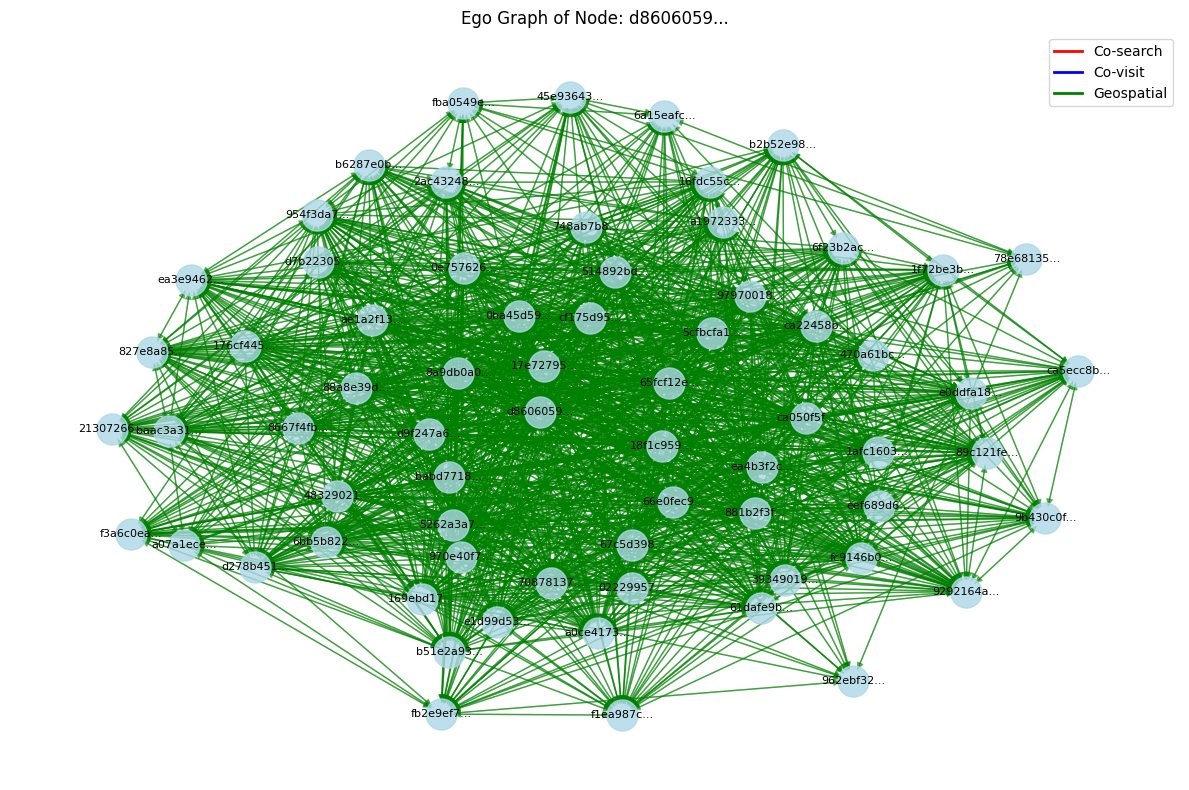

In [ ]:
import matplotlib.pyplot as plt

print("\n" + "="*70)
print("SUBGRAPH VISUALIZATION")
print("="*70)

# Pick a high-degree node to visualize its neighborhood
high_degree_node = max(G.degree(), key=lambda x: x[1])[0]

print(f"\nVisualizing neighborhood of node: {high_degree_node}")
print(f"Degree: {G.degree(high_degree_node)}")

# Get ego graph (node + its neighbors)
ego_graph = nx.ego_graph(G, high_degree_node, radius=1)

print(f"Ego graph has {ego_graph.number_of_nodes()} nodes and {ego_graph.number_of_edges()} edges")

# Color edges by type
edge_colors = []
for u, v, data in ego_graph.edges(data=True):
    edge_type = data.get('edge_type', 'unknown')
    if edge_type == 'co-search':
        edge_colors.append('red')
    elif edge_type == 'co-visit':
        edge_colors.append('blue')
    elif edge_type == 'geospatial':
        edge_colors.append('green')
    else:
        edge_colors.append('gray')

# Draw
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(ego_graph, k=2, iterations=50)

# Draw nodes
nx.draw_networkx_nodes(ego_graph, pos, node_color='lightblue', 
                       node_size=500, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(ego_graph, pos, edge_color=edge_colors, 
                       alpha=0.5, arrows=True, arrowsize=10)

# Draw labels (truncated for readability)
for node in G.nodes():
    G.add_edge(node, node, edge_type='self', weight=1.0, raw_count=1)
# labels = {node: node[:8] + '...' for node in ego_graph.nodes()}
nx.draw_networkx_labels(ego_graph, pos, labels, font_size=8)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Co-search'),
    Line2D([0], [0], color='blue', lw=2, label='Co-visit'),
    Line2D([0], [0], color='green', lw=2, label='Geospatial')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.title(f"Ego Graph of Node: {high_degree_node[:8]}...")
plt.axis('off')
plt.tight_layout()
plt.savefig('graph_visualization.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved visualization to 'graph_visualization.png'")
plt.show()

In [68]:
# Node degree distribution
print("\n" + "="*70)
print("NODE DEGREE ANALYSIS")
print("="*70)

in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

print(f"\nIn-degree statistics:")
print(f"  Mean: {pd.Series(in_degrees.values()).mean():.2f}")
print(f"  Median: {pd.Series(in_degrees.values()).median():.0f}")
print(f"  Max: {pd.Series(in_degrees.values()).max()}")
print(f"  Min: {pd.Series(in_degrees.values()).min()}")

print(f"\nOut-degree statistics:")
print(f"  Mean: {pd.Series(out_degrees.values()).mean():.2f}")
print(f"  Median: {pd.Series(out_degrees.values()).median():.0f}")
print(f"  Max: {pd.Series(out_degrees.values()).max()}")
print(f"  Min: {pd.Series(out_degrees.values()).min()}")

# Top 10 nodes by in-degree
print(f"\nTop 10 nodes by in-degree:")
sorted_in = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
for node, degree in sorted_in:
    print(f"  {node}: {degree}")

# Top 10 nodes by out-degree
print(f"\nTop 10 nodes by out-degree:")
sorted_out = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
for node, degree in sorted_out:
    print(f"  {node}: {degree}")


NODE DEGREE ANALYSIS

In-degree statistics:
  Mean: 23.89
  Median: 18
  Max: 67
  Min: 0

Out-degree statistics:
  Mean: 23.89
  Median: 17
  Max: 67
  Min: 0

Top 10 nodes by in-degree:
  d8606059-6e36-451d-bc28-89b3d3024bd6: 67
  ca050f5f-3385-482c-a0ab-91506f9d3b0f: 65
  ca22458b-13f2-432d-8803-e9b81b78a500: 64
  16fdc55c-38ca-4eac-ba7f-38ecabb35560: 64
  5262a3a7-4b74-4d82-9fa5-d41503252888: 64
  2ac43248-e4e1-485d-b43c-6866a359a10c: 63
  65fcf12e-c0da-482f-826e-74be924e81c2: 63
  954f3da7-b013-4eca-b689-1bc283c462d6: 63
  970e40f7-ffaf-41ae-b1d3-d00baae48bcb: 63
  1afc1603-c926-496e-b33e-12b3d749b8e1: 62

Top 10 nodes by out-degree:
  d8606059-6e36-451d-bc28-89b3d3024bd6: 67
  ca050f5f-3385-482c-a0ab-91506f9d3b0f: 65
  ca22458b-13f2-432d-8803-e9b81b78a500: 64
  16fdc55c-38ca-4eac-ba7f-38ecabb35560: 64
  5262a3a7-4b74-4d82-9fa5-d41503252888: 64
  65fcf12e-c0da-482f-826e-74be924e81c2: 63
  954f3da7-b013-4eca-b689-1bc283c462d6: 63
  970e40f7-ffaf-41ae-b1d3-d00baae48bcb: 63
  2ac432

In [69]:
print("\n" + "="*70)
print("EDGE TYPE ANALYSIS")
print("="*70)

# Count edges by type
edge_types = {}
edge_weights = {}

for u, v, data in G.edges(data=True):
    edge_type = data.get('edge_type', 'unknown')
    
    if edge_type not in edge_types:
        edge_types[edge_type] = 0
        edge_weights[edge_type] = []
    
    edge_types[edge_type] += 1
    edge_weights[edge_type].append(data.get('weight', 0))

print("\nEdges by type:")
for edge_type, count in sorted(edge_types.items(), key=lambda x: x[1], reverse=True):
    print(f"  {edge_type}: {count}")
    
    weights = edge_weights[edge_type]
    print(f"    Weight stats: mean={np.mean(weights):.4f}, "
          f"median={np.median(weights):.4f}, "
          f"min={np.min(weights):.4f}, "
          f"max={np.max(weights):.4f}")

# Sample edges of each type
print("\n" + "="*70)
print("SAMPLE EDGES BY TYPE")
print("="*70)

for edge_type in edge_types.keys():
    print(f"\n{edge_type.upper()} edges (showing first 5):")
    count = 0
    for u, v, data in G.edges(data=True):
        if data.get('edge_type') == edge_type:
            print(f"  {u[:8]}... -> {v[:8]}... | "
                  f"weight: {data.get('weight', 0):.4f} | "
                  f"count: {data.get('raw_count', 'N/A')}")
            count += 1
            if count >= 5:
                break


EDGE TYPE ANALYSIS

Edges by type:
  geospatial: 5608
    Weight stats: mean=0.5097, median=0.4703, min=0.3333, max=0.9931
  co-visit: 4
    Weight stats: mean=1.0000, median=1.0000, min=1.0000, max=1.0000
  co-search: 1
    Weight stats: mean=1.0000, median=1.0000, min=1.0000, max=1.0000

SAMPLE EDGES BY TYPE

GEOSPATIAL edges (showing first 5):
  90b50920... -> 61dafe9b... | weight: 0.4279 | count: N/A
  90b50920... -> 470a61bc... | weight: 0.4893 | count: N/A
  90b50920... -> cf175d95... | weight: 0.3792 | count: N/A
  90b50920... -> ad198034... | weight: 0.5207 | count: N/A
  90b50920... -> 176cf445... | weight: 0.3354 | count: N/A

CO-VISIT edges (showing first 5):
  ea3e9462... -> 71542de4... | weight: 1.0000 | count: 1
  27d63724... -> 881b2f3f... | weight: 1.0000 | count: 1
  80474f1c... -> 2a515e05... | weight: 1.0000 | count: 1
  4e13998f... -> adce7f4e... | weight: 1.0000 | count: 1

CO-SEARCH edges (showing first 5):
  2e010c1e... -> 2ac43248... | weight: 1.0000 | count: 1